In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

%config InlineBackend.figure_format = 'retina'

In [3]:
g = nx.Graph()
edges_with_atts = [
    (1, 2, {"length": 5}),
    (1, 3, {"length": 11}),
    (2, 4, {"length": 4}),
    (2, 5, {"length": 7}),
]
g.add_edges_from(edges_with_atts)

lengths = nx.all_pairs_dijkstra_path(g, weight="length", cutoff=8)
dict(map(lambda x: (x[0], set(x[1].keys()) - {x[0]}), lengths))

{1: {2}, 2: {1, 4, 5}, 3: set(), 4: {2}, 5: {2}}

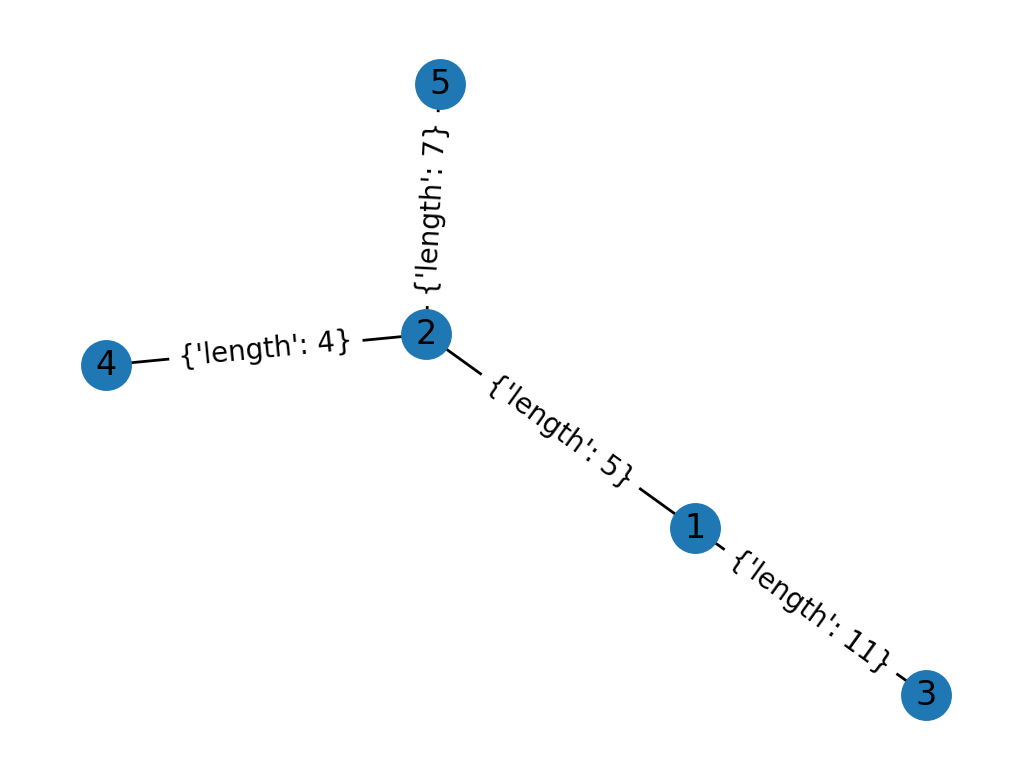

In [4]:
layout = nx.spring_layout(g)
nx.draw_networkx(g, pos=layout)
nx.draw_networkx_edge_labels(g, pos=layout)
plt.axis("off")
plt.show()

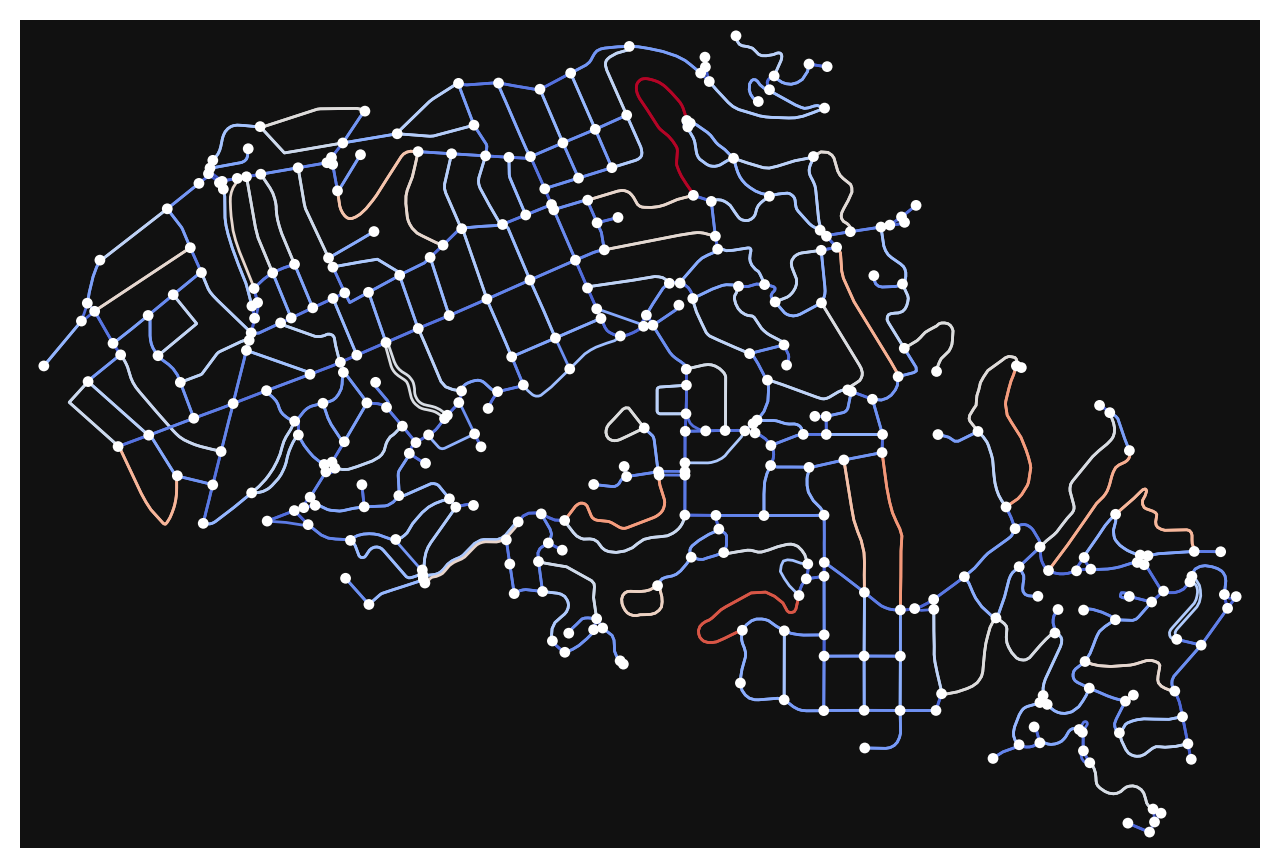

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
import osmnx as ox

G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
ec = ox.plot.get_edge_colors_by_attr(G, attr="travel_time", cmap="coolwarm")
ox.plot_graph(G, edge_color=ec)

### A* Implementation

In [48]:
# Heuristics - Euclidean distance


def heuristic(u, v, G):
    u_attrs = G.nodes[u]
    v_attrs = G.nodes[v]
    if "x" in u_attrs and "y" in u_attrs and "x" in v_attrs and "y" in v_attrs:
        (x1, y1) = (u_attrs["x"], u_attrs["y"])
        (x2, y2) = (v_attrs["x"], v_attrs["y"])
        return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    else:
        return abs(u - v)


def all_pairs_astar_path(G, time, weight="travel_time"):
    paths = {}
    for source in G.nodes():
        paths[source] = {}
        for target in G.nodes():
            if source != target:
                try:
                    length = nx.astar_path_length(
                        G,
                        source,
                        target,
                        heuristic=lambda u, v: heuristic(u, v, G),
                        weight=weight,
                        cutoff=time,
                    )
                    paths[source][target] = length
                except nx.NetworkXNoPath:
                    paths[source][target] = float("inf")
    return paths


def get_driveshed_size(G, time=30):
    drivesheds = all_pairs_astar_path(G, time, weight="travel_time")
    reachable_nodes = {
        node: {nbr for nbr, dist in paths.items() if dist <= time}
        for node, paths in drivesheds.items()
    }
    G = G.copy()
    nx.set_node_attributes(G, reachable_nodes, "reachable_nodes")
    return G

In [49]:
G = get_driveshed_size(G, time=30)

In [51]:
%timeit get_driveshed_size(G)

3.62 s ± 52.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


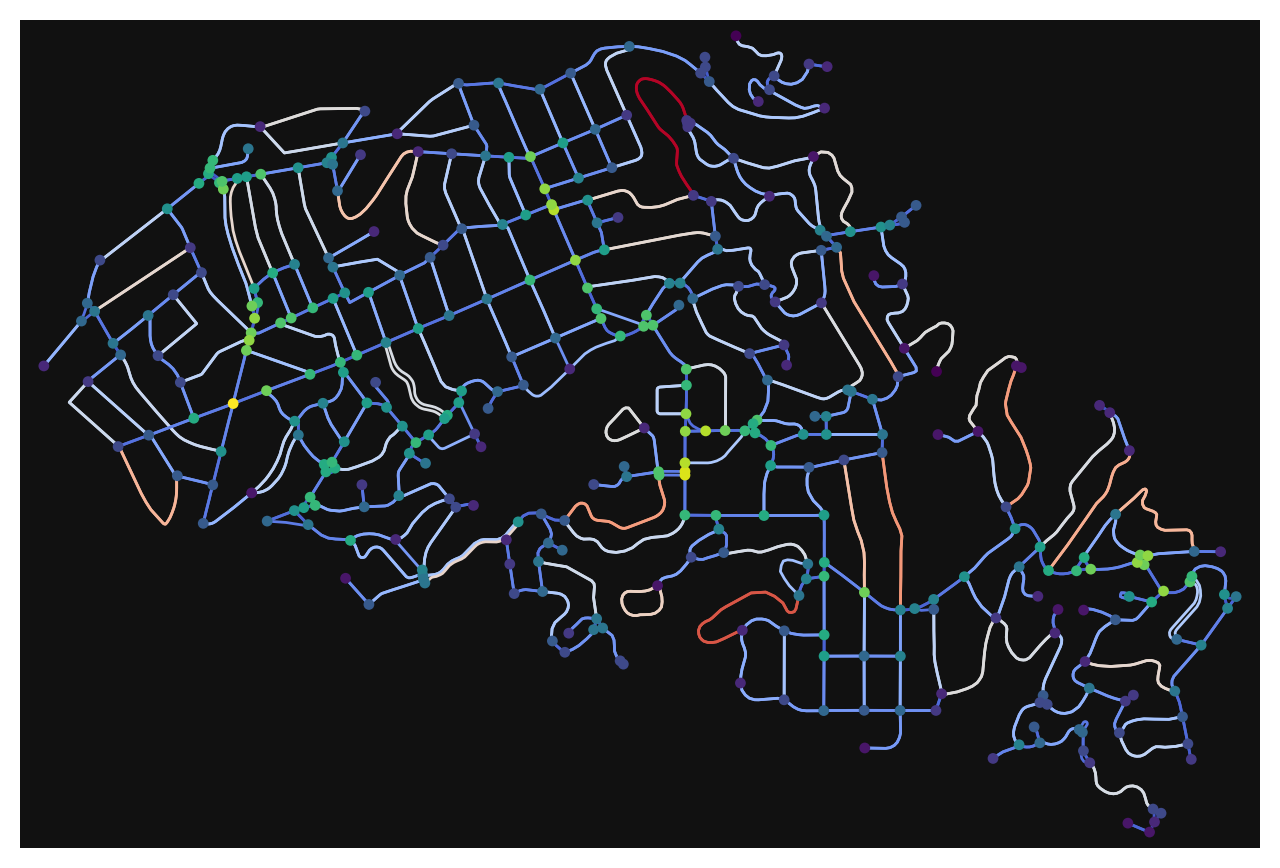

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [50]:
num_reachable_nodes = dict(
    map(
        lambda x: (x[0], len(x[1])),
        nx.get_node_attributes(G, "reachable_nodes").items(),
    )
)
nx.set_node_attributes(G, num_reachable_nodes, "num_reachable_nodes")
nd = ox.plot.get_node_colors_by_attr(G, attr="num_reachable_nodes", cmap="viridis")
ox.plot_graph(G, node_color=nd, edge_color=ec)

In [40]:
G.nodes[53017091]

{'y': 37.8262501, 'x': -122.2476037, 'street_count': 3}